# Part 5: Recurrent Neural Network

### In this section, the cleaned text will be converted to a suitable form using GloVe embedding, then used to train a RNN with LSTM layer.

### This section will also explore and test different methods of fine-tuning the RNN and evaluating its effectiveness

In [ ]:
import sys
!{sys.executable} -m pip install pandas_profiling
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install scikit-learn-intelex
!{sys.executable} -m pip install tensorflow==2.9.0 --user
!{sys.executable} -m spacy download en_core_web_md
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install unzip

In [3]:
!{sys.executable} -m wget http://nlp.stanford.edu/data/glove.6B.zip


Saved under glove.6B.zip


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from itertools import product
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D, LeakyReLU
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11
MAX_FEATURES = 50000
MAX_LEN = 200
EMBEDDING_DIM = 100
print(tf.__version__)

2.9.0


Use CUDA DNN acceleration

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)


#### The pre-processed text is read from csv

In [3]:
df = pd.read_csv(PROJ_DIR + r"\sc1015-project\dataset\fake_job_postings.csv")

cleaned_text = pd.read_csv('lemmatized_text.csv').squeeze() # convert to pd series


#### Use GloVe model for embedding layer

In [4]:
embeddings_index = {}
with open('glove_embeddings/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

#### Next, the text will be tokenized

In [5]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(cleaned_text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(cleaned_text)
ml_seq = pad_sequences(sequences, maxlen=MAX_LEN)

#### Form embedding matrix to be used in the RNN

In [6]:
num_words = min(MAX_FEATURES, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### The resulting padded data is split and the train set is resampled with ADASYN to compensate class imbalance

In [7]:
sss=StratifiedShuffleSplit(n_splits=1, random_state=RANDOM_SPLIT_SEED, test_size=0.2)
X=np.zeros(shape=ml_seq.shape[0],dtype=np.bool_)
y=np.array(df['fraudulent']) # prediction target
for train_index, test_index in sss.split(X, y):
    X_train, X_test = ml_seq[train_index,:], ml_seq[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

X_res, y_res = adasyn.fit_resample(X_train, y_train)
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### This section defines the RNN and its output layers, as well as tests the effectiveness of different number of LSTM units.
**The embedded layer uses a non-trainable matrix as defined previously, derived from the GloVe model,
followed by a bi-directional LSTM to help with memory in time domain,
followed by a max pooling layer to summarize max vals in time domain,
then 3 successive layers of dense and dropout
The output activation is sigmoid so it can be rounded to a boolean value.
LeakyRelu activation function was used to mitigate the dying Relu problem**

In [16]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          5000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 256)         234496    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_9 (Dropout)         (None, 256)              

Epoch 1/50
423/423 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9444
Epoch 1: val_loss improved from inf to 0.17023, saving model to rnn_weights.h5
423/423 [==============================] - 59s 126ms/step - loss: 0.1409 - accuracy: 0.9444 - val_loss: 0.1702 - val_accuracy: 0.9360
Epoch 2/50
423/423 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9822
Epoch 2: val_loss improved from 0.17023 to 0.07313, saving model to rnn_weights.h5
423/423 [==============================] - 62s 145ms/step - loss: 0.0576 - accuracy: 0.9822 - val_loss: 0.0731 - val_accuracy: 0.9787
Epoch 3/50
423/423 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9881
Epoch 3: val_loss did not improve from 0.07313
423/423 [==============================] - 55s 129ms/step - loss: 0.0388 - accuracy: 0.9881 - val_loss: 0.1052 - val_accuracy: 0.9737
Epoch 4/50
423/423 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9905
Epoch

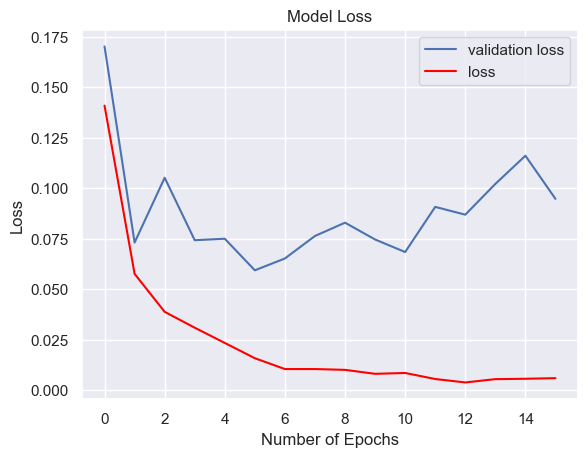

In [17]:
# Define the callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('rnn_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

hist = model.fit(X_res,y_res,validation_data=(X_test,y_test),epochs=50,batch_size=64, callbacks=[early_stop, model_checkpoint])
# Load the best model weights
model.load_weights('rnn_weights.h5')

plt.plot(hist.history['val_loss'], color='b', label="validation loss")
plt.plot(hist.history['loss'], color='red', label="loss")
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
test_probs = model.predict(X_test, batch_size=64)
test_preds = (test_probs >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, test_preds)

print(f"RNN test accuracy score : {test_accuracy}")

56/56 [==============================] - 4s 46ms/step
RNN test accuracy score : 0.9835011185682326


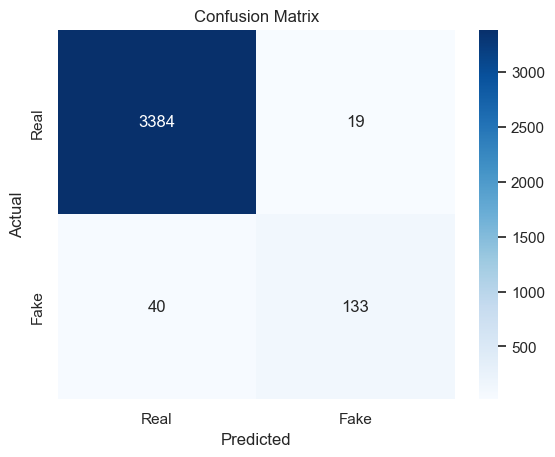

True Positive Rate: 0.7687861271676301
True Negative Rate: 0.9944166911548633
False Positive Rate: 0.005583308845136644
False Negative Rate: 0.23121387283236994
Accuracy: 0.9835011185682326
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.88      0.77      0.82       173

    accuracy                           0.98      3576
   macro avg       0.93      0.88      0.90      3576
weighted avg       0.98      0.98      0.98      3576



In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Define the class labels
class_names = ['Real', 'Fake']

# Create a heatmap of the confusion matrix
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

TPR = TP / (TP + FN)
print("True Positive Rate:", TPR)
TNR = TN / (TN + FP) 
print("True Negative Rate:", TNR)
FPR = FP / (FP + TN)
print("False Positive Rate:", FPR)
FNR = FN / (TP + FN)
print("False Negative Rate:", FNR)
ACC = (TP + TN) / (TP + FP + FN + TN)
print("Accuracy:", ACC)

print(metrics.classification_report(y_test, test_preds))

### Conclusion for Recurrent Neural Network model

**In conclusion, the best overall performance was achieved using a single LSTM layer of 128 units, yielding f1-score of 0.99/0.82, 0.99 TNR, 0.77 TPR. Addition of the globalmaxpooling and dropout/dense layers helped with improving the generalization of the model.**